In [1]:
import numpy as np
import scipy.interpolate as spip
import h5py

from pbh import compute_evolution
from temperature import Hawking_temperature
from utils import load_CDF_data, progress_bar

In [2]:
CDF_data = load_CDF_data("CDF_data.h5")
CDF_vals = CDF_data[:, 0]
x_vals = CDF_data[:, 1]

inv_CDF_interp = spip.CubicSpline(CDF_vals, x_vals)

temperature_f = Hawking_temperature("Kerr")

In [51]:
# Size of arrays to be contructed (this is a conservative value which 
# works for all masses up to 100 since this is the value we are trying 
# to predict in this notebook)
N = 50000

# Array of values for the initial mass M
# M_values = np.arange(2., 101., 1.)
M_values = np.logspace(np.log10(2), np.log10(100), num=100, endpoint=True)
M_values = [np.around(M, 2) for M in M_values]

# How many repetitions to do for each value of the initial mass
N_reps = 10000

# Initial value for the angular momentum of the black hole
J_init = 0.

# Path to the file where the results from the run will be saved
results_file = "./data/sequential_data.csv"


In [53]:
prefix_padding = len(str(np.max(M_values))) + 5
length = 63

for M_init in M_values:
    N_steps_vals = []

    progress_bar_prefix = f"M = {M_init}:".ljust(prefix_padding)
    progress_bar(0, N_reps, prefix=progress_bar_prefix, length=length)
    
    for i in range(N_reps):
        rands = np.random.uniform(
            size=N,
            low=CDF_vals[0],
            high=CDF_vals[-1],
        )
        changes_array = inv_CDF_interp(rands)
        rands_array = np.random.rand(N)

        (M, J, a, n, extremal, path), time = compute_evolution(
            M_init, 1.,
            J_init,
            temperature_f,
            changes_array, rands_array,
        )

        N_steps_vals.append(n)

        with open(results_file, "a") as f:
            f.write(f"{M_init},{J_init},{M},{J},{a},{n},{time:.3e}\n")

        progress_bar(i + 1, N_reps, prefix=progress_bar_prefix, length=length)

    with h5py.File("data/predictive_vals.h5", 'a') as f:
        f.create_dataset(
            str(M_init),
            data=N_steps_vals,
            compression="gzip",
            compression_opts=9,
        )

with h5py.File("data/predictive_vals.h5", 'a') as f:
    f.create_dataset(
        "M_values",
        data=M_values,
        compression="gzip",
        compression_opts=9,
    )
        

M = 2.0:   |███████████████████████████████████████████████████████████████| 100.0% 
M = 2.08:  |███████████████████████████████████████████████████████████████| 100.0% 
M = 2.16:  |███████████████████████████████████████████████████████████████| 100.0% 
M = 2.25:  |███████████████████████████████████████████████████████████████| 100.0% 
M = 2.34:  |███████████████████████████████████████████████████████████████| 100.0% 
M = 2.44:  |███████████████████████████████████████████████████████████████| 100.0% 
M = 2.54:  |███████████████████████████████████████████████████████████████| 100.0% 
M = 2.64:  |███████████████████████████████████████████████████████████████| 100.0% 
M = 2.74:  |███████████████████████████████████████████████████████████████| 100.0% 
M = 2.85:  |███████████████████████████████████████████████████████████████| 100.0% 
M = 2.97:  |███████████████████████████████████████████████████████████████| 100.0% 
M = 3.09:  |█████████████████████████████████████████████████████

In [47]:
from tabulate import tabulate

n_iters_min = []
n_iters_median = []
n_iters_max = []

for M in M_values:
    with h5py.File("data/predictive_vals.h5", 'r') as f:
        data = f[str(M)][:]
        n_iters_min.append(np.min(data))
        n_iters_median.append(np.median(data))
        n_iters_max.append(np.max(data))
        
headers = ["Initial mass", "Min", "Median", "Max"]
contents = [
    [M, x, y, z]
    for M, x, y, z in zip(M_values, n_iters_min, n_iters_median, n_iters_max)
]

print(tabulate(contents, headers=headers, tablefmt="grid"))

+----------------+-------+----------+-------+
|   Initial mass |   Min |   Median |   Max |
+================+=======+==========+=======+
|          2     |     4 |       15 |    26 |
+----------------+-------+----------+-------+
|          3.089 |    21 |       41 |    57 |
+----------------+-------+----------+-------+
|          4.771 |    75 |      103 |   133 |
+----------------+-------+----------+-------+
|          7.368 |   214 |      251 |   289 |
+----------------+-------+----------+-------+
|         11.38  |   543 |      601 |   662 |
+----------------+-------+----------+-------+
|         17.575 |  1353 |     1437 |  1549 |
+----------------+-------+----------+-------+
|         27.144 |  3295 |     3427 |  3579 |
+----------------+-------+----------+-------+
|         41.923 |  7945 |     8176 |  8381 |
+----------------+-------+----------+-------+
|         64.748 | 19197 |    19503 | 19875 |
+----------------+-------+----------+-------+
|        100     | 45835 |    4652

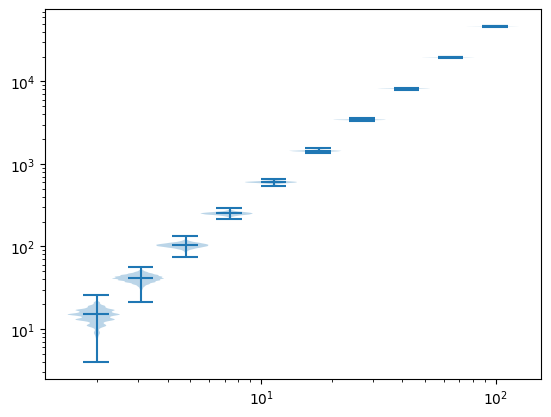

In [50]:
import matplotlib.pyplot as plt

M_chosen_idx = [i for i in range(10)]
M_chosen = M_values[:]
violin_plot_data = []

plt.figure()

for M in M_chosen:
    with h5py.File("data/predictive_vals.h5", 'r') as f:
        violin_plot_data.append(f[str(M)][:])

plt.violinplot(
    violin_plot_data,
    positions=M_chosen,
    widths=np.array(M_chosen) / 2,
    showmeans=False,
    showmedians=True,
)

plt.xscale('log')
plt.yscale('log')

plt.show()


In [7]:
from sklearn.linear_model import LinearRegression

model_min = LinearRegression().fit(
    np.log10(M_values).reshape((-1, 1)),
    np.log10(n_iters_min),
)
model_median = LinearRegression().fit(
    np.log10(M_values).reshape((-1, 1)),
    np.log10(n_iters_median),
)
model_max = LinearRegression().fit(
    np.log10(M_values).reshape((-1, 1)),
    np.log10(n_iters_max),
)


In [8]:
M_predict = np.linspace(1e1, 1e5, 10000)
N_predict = 10**model_max.predict(np.log10(M_predict).reshape((-1, 1)))


In [9]:
# Safety factor to use
safety_factor = 1.05

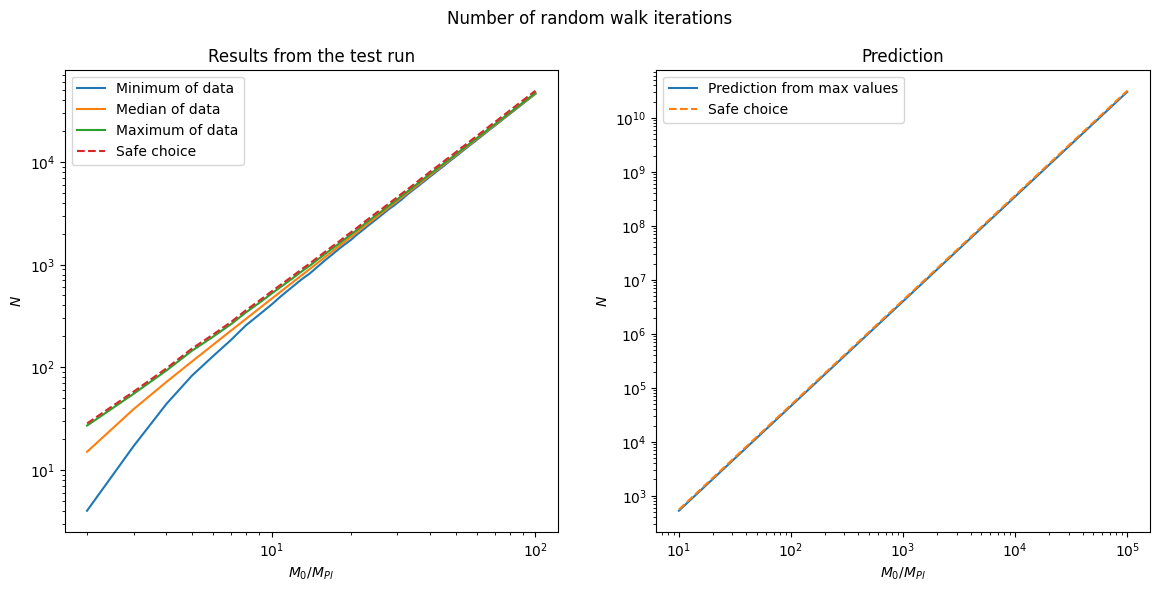

In [13]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

fig.suptitle("Number of random walk iterations")

ax1.plot(M_values, n_iters_min, label="Minimum of data")
ax1.plot(M_values, n_iters_median, label="Median of data")
ax1.plot(M_values, n_iters_max, label="Maximum of data")

N_safe = safety_factor * np.array(n_iters_max)
ax1.plot(M_values, N_safe, ls="--", label="Safe choice")

ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlabel(r"$M_{0} / M_{Pl}$")
ax1.set_ylabel(r"$N$")

ax1.legend()
ax1.set_title("Results from the test run")

ax2.plot(M_predict, N_predict, label="Prediction from max values")

N_safe_test = safety_factor * N_predict

ax2.plot(M_predict, N_safe_test, ls="--", label="Safe choice")

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2.set_xlabel(r"$M_{0} / M_{Pl}$")
ax2.set_ylabel(r"$N$")

ax2.legend()
ax2.set_title("Prediction")

plt.show()

In [14]:
# Get the slope and intercept of the linear regression model for max values
slope = model_max.coef_[0]
y_intercept = model_max.intercept_

In [15]:
python_file_contents_raw = """import numpy as np
import numba as nb

from numbers import Real, Integral

@nb.njit(fastmath = True)
def predict_size(M: Real, extra_factor: Real = 1.) -> Integral:
    \"\"\"
    Predict the size of the arrays changes and rands needed for the 
    compute_BH_evolution function. The parameters within are derived in 
    the predict_size.ipynb notebook.

    Parameters:
    M (Real): the initial mass of the black hole (in Planck masses)
    extra_factor (Real): extra factor for multiplying the size that can 
        be provided by the user

    Returns:
    Integral: the predicted size for the arrays
    \"\"\"
    log_log_intercept = {}
    log_log_coef = {}

    log_M = np.log10(M)
    log_N_predict = log_log_intercept + log_log_coef * log_M
    N_predict = 10**log_N_predict

    N_predict *= 1.05
    N_predict *= extra_factor

    N_predict = int(np.ceil(N_predict))
    return N_predict

"""

In [16]:
file_contents = python_file_contents_raw.format(y_intercept, slope)

print(file_contents)

with open("predict_size.py", "w") as f:
    f.write(file_contents)

import numpy as np
import numba as nb

from numbers import Real, Integral

@nb.njit(fastmath = True)
def predict_size(M: Real, extra_factor: Real = 1.) -> Integral:
    """
    Predict the size of the arrays changes and rands needed for the 
    compute_BH_evolution function. The parameters within are derived in 
    the predict_size.ipynb notebook.

    Parameters:
    M (Real): the initial mass of the black hole (in Planck masses)
    extra_factor (Real): extra factor for multiplying the size that can 
        be provided by the user

    Returns:
    Integral: the predicted size for the arrays
    """
    log_log_intercept = 0.7827043603150012
    log_log_coef = 1.9397332751537197

    log_M = np.log10(M)
    log_N_predict = log_log_intercept + log_log_coef * log_M
    N_predict = 10**log_N_predict

    N_predict *= 1.05
    N_predict *= extra_factor

    N_predict = int(np.ceil(N_predict))
    return N_predict


